In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/watai-open-project-f23-beginner-classical-ml/beginner_data_cml.npz


In [2]:
import numpy as np

with np.load("/kaggle/input/watai-open-project-f23-beginner-classical-ml/beginner_data_cml.npz") as data:
    X_train = data['train_images']  # Shape (8981, 64, 64, 3)
    y_train = data['train_labels']  # Shape (8981,)
    X_test = data['test_images']  # Shape (1800, 64, 64, 3)
    # we don't have y_test because the labels for the test is the basis of the scoring in the competition...

In [3]:
#creating target vectors for the classification task...
y_train_1 = (y_train == 1)

In [4]:
#Starting with the stochastic gradient descent model, a good binary model

from sklearn.linear_model import SGDClassifier #importing model


In [5]:
# Reshape the image data to 2D
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Flatten each image
# Make sure to apply the same reshaping procedure to the test data when you want to make predictions on it.

# Create the SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

# Fit the classifier with the flattened data
sgd_clf.fit(X_train_flattened, y_train_1)


SGDClassifier(random_state=42)

In [6]:
#measuring accuracy using cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_flattened, y_train_1, cv=3, scoring="accuracy")
#above, we're using 3 folds, for no reason tbh...

array([0.65263861, 0.6997328 , 0.62813231])

In [7]:
#yo we got accuracy in the 60s... could be just bc we have 60% of the images as cabinets 🤔

Instead of cross_validation, we should use a confusion matrix and plot a precision/recall graph...

In [8]:
#first, we need a set of predictions so that they can be compared to the actual targets, that's what this code is for:

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train_flattened, y_train_1, cv=3)

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_1, y_train_pred) # making the confusion matrix
cm # spitting it out

array([[2313, 2330],
       [ 722, 3616]])

Here, we can see that 2313 of them are correctly classified as bikes (TRUE NEGATIVES), 2330 are classified as cabinets (but are actually bikes) (FALSE POSITIVES), 722 of them are cabinets but are classified as bikes (FALSE NEGATIVES), and 3616 of them are correctly predicted as cabinets (TRUE POSITIVES). We gotta reduce the # of false positives and the false negatives...

Now, let's plot the precision/recall (or the ROC curve (probably not, we care more about false positives here)), and see if we have any better models (maybe RandomTree???) 

In [10]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_1, y_train_pred)

0.6081399260006727

In [11]:
recall_score(y_train_1, y_train_pred)

0.8335638543107423

In [12]:
#comparing precision to recall...
from sklearn.metrics import f1_score
f1_score(y_train_1, y_train_pred)

0.7032283158304162

Now, trying a better classifier (RandomForestClassifier)...

In [13]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [14]:
#dosen't have decision_function() method, so we need its predict_proba() method that returns class probabilties for each instance
y_probas_forest = cross_val_predict(forest_clf, X_train_flattened, y_train_1, cv=3, method="predict_proba")
y_probas_forest[:2]

array([[0.48, 0.52],
       [0.88, 0.12]])

In [15]:
from sklearn.metrics import precision_recall_curve
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_1, y_scores_forest)

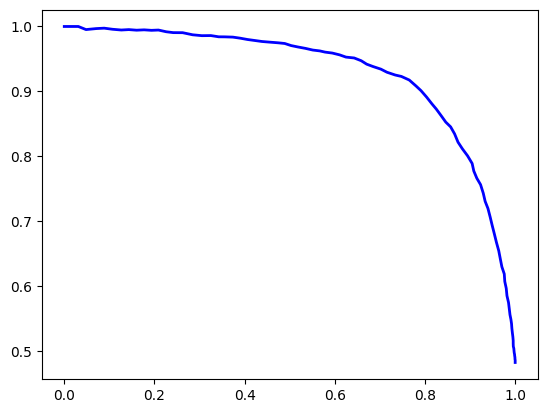

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train_flattened, y_train_1, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)


plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.show()

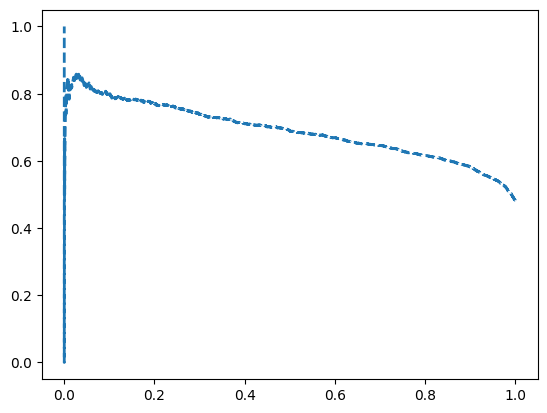

In [17]:
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

As we can see, the RandomForest has a greater AUC as compared to the SGD...